## 实战 Kaggle 比赛：狗的品种识别（ImageNet Dogs）
比赛网址是 https://www.kaggle.com/c/dog-breed-identification

In [1]:
# 下面两行是防止内核挂掉加的
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

读取数据集所在地址

In [2]:
d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip',
                            '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

demo = False # 如果为真，则使用小部分数据集，这里我们使用完整的数据集
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'data', 'dog-breed-identification')

整理数据集：将每个类存放一个文件夹

In [3]:
def read_csv_labels(fname):
    """读取 `fname` 来给标签字典返回一个文件名。"""
    with open(fname, 'r') as f:
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'labels.csv')) # 存放训练集标签的文件
labels # 是一个字典

{'000bec180eb18c7604dcecc8fe0dba07': 'boston_bull',
 '001513dfcb2ffafc82cccf4d8bbaba97': 'dingo',
 '001cdf01b096e06d78e9e5112d419397': 'pekinese',
 '00214f311d5d2247d5dfe4fe24b2303d': 'bluetick',
 '0021f9ceb3235effd7fcde7f7538ed62': 'golden_retriever',
 '002211c81b498ef88e1b40b9abf84e1d': 'bedlington_terrier',
 '00290d3e1fdd27226ba27a8ce248ce85': 'bedlington_terrier',
 '002a283a315af96eaea0e28e7163b21b': 'borzoi',
 '003df8b8a8b05244b1d920bb6cf451f9': 'basenji',
 '0042188c895a2f14ef64a918ed9c7b64': 'scottish_deerhound',
 '004396df1acd0f1247b740ca2b14616e': 'shetland_sheepdog',
 '0067dc3eab0b3c3ef0439477624d85d6': 'walker_hound',
 '00693b8bc2470375cc744a6391d397ec': 'maltese_dog',
 '006cc3ddb9dc1bd827479569fcdc52dc': 'bluetick',
 '0075dc49dab4024d12fafe67074d8a81': 'norfolk_terrier',
 '00792e341f3c6eb33663e415d0715370': 'african_hunting_dog',
 '007b5a16db9d9ff9d7ad39982703e429': 'wire-haired_fox_terrier',
 '007b8a07882822475a4ce6581e70b1f8': 'redbone',
 '007ff9a78eba2aebb558afea3a51c469'

In [4]:
def copyfile(filename, target_dir):
    """将文件复制到目标目录。"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
    # 下面的collections.Counter就是统计label这个字典中有几个类别（返回字典）；.most_common()则转换成元组；[-1][1]则返回最后一个元组的第二个值(因为这个类别数量最小)
    n = collections.Counter(labels.values()).most_common()[-1][1] # n就是最小类别的数量
    n_valid_per_label = max(1, math.floor(n * valid_ratio)) # 根据最小类别数量，得出验证集的数量
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')): # os.listdir返回训练集中的图片名字列表
        label = labels[train_file.split('.')[0]] # labels是一个字典，将每个图片名字由.分开，作为字典的key，得出对应的标签
        fname = os.path.join(data_dir, 'train', train_file) # 每个图片的完整路径
        copyfile(
            fname,
            os.path.join(data_dir, 'train_valid_test', 'train_valid', label)) # 将图片复制到指定的目录下，这个是为了交叉验证使用，这里和训练集没区别
        if label not in label_count or label_count[label] < n_valid_per_label: # 制作验证集。注：标签名作为key,value为每个标签的图片数量
            copyfile(
                fname,
                os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1 # 统计每个标签的图片数量
        else: # 制作训练集
            copyfile(
                fname,
                os.path.join(data_dir, 'train_valid_test', 'train', label))
    return n_valid_per_label # 返回验证集的数量

在预测期间整理测试集，以方便读取

In [5]:
def reorg_test(data_dir):
    for test_file in os.listdir(os.path.join(data_dir, 'test')): # 一行一行读取test文件夹下的图片，复制到指定文件夹下
        copyfile(
            os.path.join(data_dir, 'test', test_file),
            os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

调用前面定义的函数，进行整理数据集

In [6]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

batch_size = 32 if demo else 128
valid_ratio = 0.1
if not os.path.exists(data_dir + "\\" + "train_valid_test"): # 判断是否已经制作好了数据集
    print("start")
    reorg_dog_data(data_dir, valid_ratio)
else:
    print("Already exists!")

Already exists!


图像增广：
这里需要说下，图像增广，这里并没有把每张图片变成多张，保存下来。而是每次读入的时候，随机的变换成一张，然后送入模型。从整个模型运行的角度出发，实际上就是将数据集变大了，因为每次送入的图片是不一样的（随机变换的）

In [7]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0), # 从图片的中心点剪裁出24*24的图片
                                             ratio=(3.0 / 4.0, 4.0 / 3.0)),
    torchvision.transforms.RandomHorizontalFlip(), # 左右翻转
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                       saturation=0.4),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], # 对图片的每个通道做均值和方差
                                     [0.229, 0.224, 0.225])])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], # 依然 对图片的每个通道做均值和方差
                                     [0.229, 0.224, 0.225])])

读取数据集

In [8]:
# ImageFolder按照文件夹顺序，进行打标签

# 训练集和交叉验证集
train_ds, train_valid_ds = [ 
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_train) for folder in ['train', 'train_valid']]

# 验证集和测试集
valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_test) for folder in ['valid', 'test']]

# 把前面的数据放入torch的DataLoader，则每次迭代时，读取一个batch
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

微调（迁移学习）预训练模型

In [9]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True) # 使用了resnet34的预训练模型
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256), nn.ReLU(), # 在后面输出层中，又增加了几层
                                            nn.Linear(256, 120))
    finetune_net = finetune_net.to(devices[0]) # 将模型送入gpu
    for param in finetune_net.features.parameters(): # 固定住预训练模型中的参数，只调节我们新加的几个层的参数
        param.requires_grad = False
    return finetune_net

计算损失

In [10]:
loss = nn.CrossEntropyLoss(reduction='none') # reduction='none'表示返回n个样本的loss

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return l_sum / n

训练函数

In [15]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0]) # 使用多gpu
    trainer = torch.optim.SGD( # 随机梯度下降
        (param for param in net.parameters() if param.requires_grad), lr=lr,
        momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay) # 使用学习率衰减
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend) # 画图
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0]) # 特征和标签都放到gpu
            trainer.zero_grad() # 梯度清零
            output = net(features) # 得出预测结果
            l = loss(output, labels).sum()
            l.backward() # 反向传播，求梯度
            trainer.step() # 更新参数
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None: # 计算验证集的loss
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.cpu().detach()))
        scheduler.step() # 一个epoch完了，衰减学习率
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

训练和验证模型

train loss 0.992, valid loss 0.753
709.0 examples/sec on [device(type='cuda', index=0)]


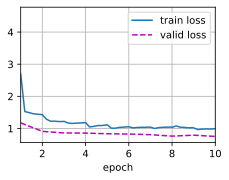

In [16]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

对测试集分类:注意，这里把每个样本对每个类别的概率都输出了（并没有取最大概率），这样就可以选择前5最大

train loss 0.978
673.4 examples/sec on [device(type='cuda', index=0)]


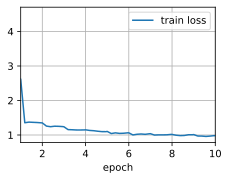

In [17]:
net = get_net(devices)
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

preds = []
for data, label in test_iter:
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=0)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(
    os.listdir(os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(
            i.split('.')[0] + ',' + ','.join([str(num)
                                              for num in output]) + '\n')

In [18]:
preds

[array([7.06965284e-06, 1.35433642e-04, 4.68443374e-11, 1.30023725e-09,
        6.41074820e-08, 2.48874716e-08, 2.11942286e-08, 2.21642807e-07,
        3.21774053e-07, 1.80562282e-07, 2.27440095e-10, 4.16191278e-06,
        9.78145009e-10, 6.42461404e-02, 7.25976085e-11, 2.90488487e-08,
        1.55184955e-06, 5.20141263e-09, 6.87180087e-04, 1.28399217e-04,
        2.18103491e-08, 3.91325557e-05, 2.27887583e-07, 9.80424957e-05,
        1.30038061e-05, 1.74569152e-07, 4.04016828e-06, 1.66156497e-05,
        4.19103756e-08, 6.28048247e-06, 5.52848251e-05, 1.42034014e-05,
        2.49879668e-04, 5.71717428e-05, 7.65299433e-07, 1.28311212e-05,
        2.01912371e-06, 2.76561440e-10, 5.71573811e-09, 2.35816056e-09,
        5.90895297e-06, 1.35682581e-06, 2.42717912e-09, 1.77294490e-09,
        1.38280967e-07, 2.22627045e-06, 1.62951572e-08, 8.47014121e-08,
        3.24340391e-07, 3.20843537e-04, 4.89214244e-06, 4.47233306e-10,
        1.82069307e-05, 3.21567384e-10, 1.68122030e-10, 3.841817